In [1]:
# %matplotlib -l

In [2]:
import ipywidgets as ipw
from ipywidgets import interact, FloatLogSlider, IntSlider, interact_manual, interactive, interactive_output, fixed

In [3]:
import matplotlib.pyplot as plt

# PLT params
%matplotlib widget
# %matplotlib inline

plt.rcParams['figure.dpi'] = 50


import numpy as np

import json

import torch
from torch.utils.data import DataLoader

import PIL
from PIL import GifImagePlugin, Image, ImageDraw, ImageFont

import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms

import foolbox as fb

In [4]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {}
_cifar_moddellocs = {
    "basemodel": './modelfolder/cifar_base.pkl',
    "PGD5": './modelfolder/cifar_pgd5.pkl',
    # "PGDDream-16itlr1e-3": 'modelfolder/cifar_PGD_dream16_1e-3.pkl',
    # "CW20-0.1": 'modelfolder/cifar_CW20.pkl'
}

for _modelname, _modelloc in _cifar_moddellocs.items():
    _model = torch.load(_modelloc, map_location=torch_device)
    _model.eval()
    models[_modelname] = _model





In [5]:
_transforms = transforms.Compose([transforms.ToTensor(),])
_to_pil = transforms.ToPILImage()

_CIFAR_data = CIFAR10(root='../../data/cifar/', train=True, download=True, transform=_transforms)
cifar_dataloader = DataLoader(dataset=_CIFAR_data, batch_size=128, shuffle=False, num_workers=0)
dataloader = cifar_dataloader

Files already downloaded and verified


In [6]:
img_b = next(iter(dataloader))
_x, _y = img_b

_unique, _inverse = torch.unique(_y, return_inverse=True, dim=0)

_perm = torch.arange(_inverse.size(0), dtype=_inverse.dtype, device=_inverse.device)

_inverse, _perm = _inverse.flip([0]), _perm.flip([0])

_first_class_idxs = _inverse.new_empty(_unique.size(0)).scatter_(0, _inverse, _perm)

_dream_imgs = _x[_first_class_idxs]
_dream_lbl = torch.arange(0, 10, 1, device=torch_device)

img_b = (_dream_imgs, _dream_lbl)

In [7]:
_x, _ = img_b
_first_img = torchvision.utils.make_grid(_x, padding=2, nrow=5, pad_value=1).detach().cpu()
_first_img = _to_pil(_first_img)

# axes = plt.imshow(_first_img, interpolation=None)
# plt.tick_params(
#     axis='both',
#     which='both',
#     bottom=False,
#     top=False,
#     labelleft=False,
#     labelbottom=False,
#     left=False)
# for pos in ['right', 'top', 'bottom', 'left']:
#     plt.gca().spines[pos].set_visible(False)
# plt.show()

In [8]:
def rescale(tensor:torch.Tensor, range:tuple = (0, 1)):
    '''Rescales tensor to a set range.'''
    tensorMin = torch.min(tensor)
    tensorMax = torch.max(tensor)
  
    return tensor.add(-1*tensorMin).div(tensorMax - tensorMin).mul(range[1] - range[0]).add(range[0])


In [9]:
class attacks_interactive():

# Initialize ipython widget populated with choices a user can make
    def __init__(self, model: torch.nn.Module, sorted_imgbatch):
        self.fmodel = fb.models.pytorch.PyTorchModel(model=model, bounds=(0,1))
        self.targeted = False
        self._eps_step = 0.01
        self._eps_num = 20
        self._l2_multiplier = 16

        self.epsilons = np.linspace(start=0, stop=self._eps_step*self._eps_num, num=self._eps_num+1)

        self.fig: plt.Figure
        self.ax: plt.Axes
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
        
        self.out_img = None

        self.perturbed_imgs = {}

        im, target = sorted_imgbatch
        self.imgs, self.targets = im.to(torch_device), target.to(torch_device)

        self.attack_dict = {
            "FGSM": {
                "random_start": ipw.Checkbox(value=True, description="Random starts"),
                # "epsilons": np.linspace(start=0, stop=self._eps_step*self._eps_num, num=self._eps_num+1)
                },

            "PGD": {
                "steps": ipw.IntSlider(value=1, min=0, max=50, description="# steps", continuous_update=False),
                "abs_stepsize":ipw.FloatLogSlider(value=0.01, base=10, min=-3, max=0, step=1/3, description="Step size", continuous_update=False),
                # "epsilons": np.linspace(start=0, stop=self._eps_step*self._eps_num, num=self._eps_num+1)
            },

            "CW": {
                "steps":ipw.IntSlider(value=1, min=0, max=50, description="# steps", continuous_update=False),
                "stepsize":ipw.FloatSlider(value=0.01, min=0, max=0.1, step=0.01, description="Step size", continuous_update=False),
                "initial_const": ipw.FloatLogSlider(value=10**-1, base=10, min=-3, max=5, step=1, description="Constant c", continuous_update=False)},
                # "epsilons": np.linspace(start=0, stop=self._eps_step*self._eps_num*16, num=self._eps_num+1)
            }

        self.attack_dropdown = ipw.Dropdown(options=[k for k in self.attack_dict.keys() if k != "epsilons"], description="Attack algorithm", value="FGSM", continuous_update=False)
        self.attack_widget = ipw.interactive_output(self.setup_controls, {"attack_id"  : self.attack_dropdown})
        self.output_w = ipw.Output()
        display(self.output_w, self.attack_dropdown, self.attack_widget)


    def setup_controls(self, attack_id="FGSM"):

        self.controls = []
        self.controls += [val for key, val in self.attack_dict[attack_id].items() if key != "epsilons"]


        eps_mul = self._l2_multiplier if self.attack_dropdown.value == "CW" else 1
        self.eps_slider = ipw.FloatSlider(value=0, min=0, max=self._eps_step*self._eps_num*eps_mul, step=self._eps_step*eps_mul, description="Epsilon", continuous_update=True)
        self.eps_slider.observe(self.eps_changed, 'value')

        self.controls.append(self.eps_slider)

        for c in self.controls:
            display(c)
        
        self.render_buttn = ipw.Button(description="Generate attack", disabled=False)
        display(self.render_buttn)
        self.render_buttn.on_click(self.render_attack)

    def render_attack(self, btn_called):    
        # Set attack vector to params
        if self.attack_dropdown.value == "FGSM":
            self.set_fgsm(*self.controls)
        if self.attack_dropdown.value == "PGD":
            self.set_pgd(*self.controls)
        if self.attack_dropdown.value == "CW":
            self.set_cw(*self.controls)

        # Clone img, execute FB attack
        perturbed_x = self.imgs[0].clone().detach().unsqueeze(0)
        fcriteria = fb.criteria.Misclassification(self.targets[0].unsqueeze(0))

        use_eps = [epsval * 16 if self.attack_dropdown.value == "CW" else epsval for epsval in self.epsilons]
        raw_advs, clipped_advs, success = self.attack(self.fmodel, perturbed_x, epsilons=use_eps, criterion=fcriteria)

        
        self.perturbed_imgs = {}
        for pert_img, eps in zip(clipped_advs, use_eps):
            pert_img= pert_img.cpu()

            pert_diff = rescale(torch.sub(pert_img, perturbed_x.cpu()))
            stacked = torch.stack([pert_img, pert_diff], dim=1).squeeze()
            
            self.perturbed_imgs[eps] = _to_pil(torchvision.utils.make_grid(stacked, nrow=2))


        # Show attack visuals 
        if self.out_img is None:
            self.out_img = self.fig.get_axes()[0].imshow(self.perturbed_imgs[self.eps_slider.value])
        else:
            self.out_img.set(data=self.perturbed_imgs[self.eps_slider.value])
        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            labelleft=False,
            labelbottom=False,
            left=False)
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)
    

    def set_fgsm(self, random_start, epsilons):
        self.attack = fb.attacks.FGSM(random_start=random_start)

    def set_pgd(self, steps, abs_stepsize, epsilons):
        self.attack = fb.attacks.LinfPGD(steps=steps.value, abs_stepsize=abs_stepsize.value)
    
    def set_cw(self, steps, stepsize, initial_const, epsilons):
        self.attack = fb.attacks.carlini_wagner.L2CarliniWagnerAttack(steps=steps.value, stepsize=stepsize.value, initial_const=initial_const.value, binary_search_steps=1, abort_early=True)


    # Todo: More safety?
    def eps_changed(self, change):
        if self.perturbed_imgs and self.out_img is not None:
            self.out_img.set(data=self.perturbed_imgs[self.eps_slider.value])



Output()

Dropdown(description='Attack algorithm', options=('FGSM', 'PGD', 'CW'), value='FGSM')

Output()

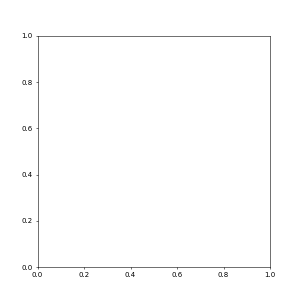

In [10]:
# iattacks = attacks_interactive(model=models["basemodel"], sorted_imgbatch=img_b)
iattacks = attacks_interactive(model=models["PGD5"], sorted_imgbatch=img_b)
